# Activation Functions

I tried to train a MLP on MNIST using various activation functions. These activation functions are :

* Sine : $f(x) = \sin(x)$
* Cosine : $f(x) = \cos(x)$
* ReLU : $f(x) = \max(0,x)$
* ReSU: $f(x) = \max \left(0, \mathrm{sign}(x) * \sqrt{|x|}\right)$
* ReLogU : $f(x) = \max\left(0, \mathrm{sign}(x) * \log(1+|x|) \right)$
* Leaky ReLu : $f(x) = \max(x, \alpha x)$, $\alpha \le 1$
* Sigmoid : $f(x) = \sigma(x) = \frac{1}{1 + \exp(-x)}$
* Tanh : $f(x) = \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$
* SimLog : $f(x) = \mathrm{sign}(x) * \log(1 + |x|)$
* SimSqrt : $f(x) = \mathrm{sign}(x) * \sqrt{|x|}$


### Importing modules

In [1]:
import torch
from torch import optim
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import sys

use_cuda = torch.cuda.is_available()

### Defining hyperparameters

In [19]:
input_size = 784
h1 = 500
h2 = 500
output_size = 10

batch_size = 32
n_epochs = 25

### Loading MNIST dataset

In [20]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#downloading datasets
training_set = MNIST('./mnist', train=True, download=True, transform=transform)
valid_set = MNIST('./mnist', train=True, download=True, transform=transform)
test_set = MNIST('./mnist', train=False, download=True, transform=transform)

num_train = len(training_set)
valid_size = len(test_set)          #valid set same size as test set
indices = list(range(num_train))

#shuffling the indices to sample training and valid dataset
np.random.seed(0)
np.random.shuffle(indices)

train_idx, valid_idx = indices[valid_size:], indices[:valid_size]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

dataloaders = {'train': DataLoader(training_set, batch_size=batch_size, sampler=train_sampler),
               'valid': DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler),
               'test': DataLoader(test_set, batch_size=batch_size)}


### Building model

In [3]:
class CustomActvClf(nn.Module):
    
    def __init__(self, actv, input_size=784, h1=500, h2=500, output_size=10):
        super(CustomActvClf, self).__init__()
        
        self.actv = actv()
        
        self.input_size = input_size
        self.h1 = h1
        self.h2 = h2
        self.output_size = output_size
        
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, output_size)
    
    def forward(self, x):
        
        x = self.actv(self.fc1(x))
        x = self.actv(self.fc2(x))
        x = self.fc3(x)
        
        return x

### Defining training and evaluation functions

In [46]:
def train(model, dataloaders, n_epochs, learning_rate=1e-3):
    
    if use_cuda:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #empty lists to track progress of loss and accuracy of datasets
    loss_tracker = []
    train_acc_tracker = []
    valid_acc_tracker = []
    test_acc_tracker = []

    for epoch in range(n_epochs):
        
        model.train()
        
        epoch_loss = 0
        n_correct = 0
        n_examples = 0
        
        for inputs, targets in dataloaders['train']:
            
            optimizer.zero_grad()
            
            inputs = inputs.view(-1, model.input_size)
            inputs, targets = Variable(inputs), Variable(targets)
            
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
                
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            epoch_loss += loss.data[0]     # for PyTorch 0.3.0
#             epoch_loss += loss.item()     # for PyTorch 0.4.0
            loss.backward()
            optimizer.step()
            
            _, predictions = outputs.max(1)
            n_correct += torch.sum(torch.eq(predictions, targets)).data[0]  # for PyTorch 0.3.0
#             n_correct += torch.sum(torch.eq(predictions, targets)).item()   # for PyTorch 0.4.0
            n_examples += len(inputs)
        
        loss_tracker.append(epoch_loss / len(dataloaders['train']))
        train_acc_tracker.append((n_correct / n_examples) * 100)
        valid_acc_tracker.append(evaluate(model, dataloaders['valid']))
        
        print("Epoch : %d ----- Loss : %.2f ----- Train acc : %.2f%% ----- Valid acc : %.2f%%"
              % (epoch, loss_tracker[-1], train_acc_tracker[-1], valid_acc_tracker[-1]))
        
    return loss_tracker, train_acc_tracker, valid_acc_tracker



In [44]:
def evaluate(model, dataloader):
    
    n_correct = 0
    n_examples = 0
    
    model.eval()
    
    for inputs, targets in dataloader:
        
        inputs = inputs.view(-1, model.input_size)

        inputs, targets = Variable(inputs), Variable(targets)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        
        _, predictions = outputs.max(1)
        n_correct += torch.sum(torch.eq(predictions, targets)).data[0]  # for PyTorch 0.3.0
#         n_correct += torch.sum(torch.eq(predictions, targets)).item()  # for PyTorch 0.4.0
        n_examples += len(inputs)
            
    accuracy = (n_correct / n_examples) * 100
    
    return accuracy

### Training models

In [2]:
import activations as actv

##### Cosine model

In [49]:
model = CustomActvClf(actv.Cos)
loss_cos, train_acc_cos, valid_acc_cos = train(model, dataloaders, n_epochs)

Epoch : 0 ----- Loss : 0.30 ----- Train acc : 90.74% ----- Valid acc : 93.39%
Epoch : 1 ----- Loss : 0.23 ----- Train acc : 93.18% ----- Valid acc : 89.13%
Epoch : 2 ----- Loss : 0.21 ----- Train acc : 93.69% ----- Valid acc : 93.34%
Epoch : 3 ----- Loss : 0.20 ----- Train acc : 94.07% ----- Valid acc : 93.38%
Epoch : 4 ----- Loss : 0.20 ----- Train acc : 93.91% ----- Valid acc : 94.63%
Epoch : 5 ----- Loss : 0.20 ----- Train acc : 94.00% ----- Valid acc : 93.73%
Epoch : 6 ----- Loss : 0.21 ----- Train acc : 93.73% ----- Valid acc : 93.42%


Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=28x28 at 0x129F7D6A0>>
Traceback (most recent call last):
  File "/Users/user/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 572, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt


KeyboardInterrupt: 

##### Sine model

In [ ]:
model = CustomActvClf(actv.Sin)
loss_sin, train_acc_sin, valid_acc_sin = train(model, dataloaders, n_epochs)

##### ReLU model

In [ ]:
model = CustomActvClf(nn.ReLU)
loss_relu, train_acc_relu, valid_acc_relu = train(model, dataloaders, n_epochs)

##### ReSU model

In [ ]:
model = CustomActvClf(actv.ReSU)
loss_resu, train_acc_resu, valid_acc_resu = train(model, dataloaders, n_epochs)

##### ReLogU model

In [ ]:
model = CustomActvClf(actv.ReLogU)
loss_relogu, train_acc_relogu, valid_acc_relogu = train(model, dataloaders, n_epochs)

##### Leaky ReLU model

In [ ]:
model = CustomActvClf(nn.LeakyReLU)
loss_leakyrelu, train_acc_leakyrelu, valid_acc_leakyrelu = train(model, dataloaders, n_epochs)

##### Sigmoid model

In [ ]:
model = CustomActvClf(nn.Sigmoid)
loss_sigmoid, train_acc_sigmoid, valid_acc_sigmoid = train(model, dataloaders, n_epochs)

##### Tanh model

In [ ]:
model = CustomActvClf(nn.Tanh)
loss_tanh, train_acc_tanh, valid_acc_tanh = train(model, dataloaders, n_epochs)

##### SimSqrt model

In [ ]:
model = CustomActvClf(actv.SimSqrt)
loss_simsqrt, train_acc_simsqrt, valid_acc_simsqrt = train(model, dataloaders, n_epochs)

##### SimLog model

In [ ]:
model = CustomActvClf(actv.SimLog)
loss_simlog, train_acc_simlog, valid_acc_simlog = train(model, dataloaders, n_epochs)

##### SoftSign model

In [ ]:
model = CustomActvClf(nn.Softsign)
loss_softsign, train_acc_softsign, valid_acc_softsign = train(model, dataloaders, n_epochs)

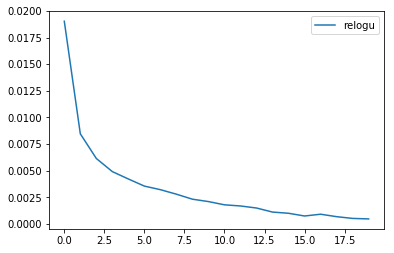

In [12]:
#plt.plot(loss_relu, label='relu')
#plt.plot(loss_leaky, label='leakytanh')
#plt.plot(loss_soft, label='softsign')
plt.plot(loss_relogu, label='relogu')
plt.legend(fancybox=True)
plt.show()

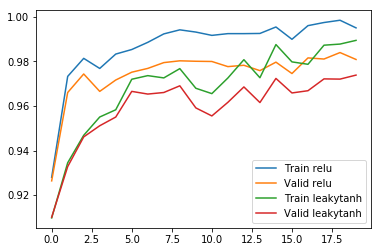

In [16]:
plt.plot(train_acc_relu, label='Train relu')
plt.plot(valid_acc_relu, label='Valid relu')
plt.plot(train_acc_leaky, label='Train leakytanh')
plt.plot(valid_acc_leaky, label='Valid leakytanh')

plt.legend(fancybox=True)
plt.show()